In [10]:
# 필요한 패키지 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, normal_ad
import warnings
warnings.filterwarnings("ignore")

# 엑셀 파일 불러오기
df = pd.read_excel("df_diff1.xlsx", index_col=0)

# 필요한 변수만 추출
df_var = df[['ROE', '연구개발비', '매출액']].dropna()

# 시계열 인덱스로 변환 (연도 데이터일 경우)
df_var.index = pd.PeriodIndex(df_var.index, freq='Q')  # 또는 freq='Y' if annual


In [11]:
# VAR 모델 적합
model = VAR(df_var)
results = model.fit(maxlags=2, ic='aic')  # maxlags는 사용자가 조절 가능
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Jul, 2025
Time:                     08:33:49
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -9.91419
Nobs:                     57.0000    HQIC:                  -10.3744
Log likelihood:           82.3681    FPE:                2.33910e-05
AIC:                     -10.6669    Det(Omega_mle):     1.65247e-05
--------------------------------------------------------------------
Results for equation ROE
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.072271         0.056302           -1.284           0.199
L1.ROE          -0.349365         0.129399           -2.700           0.007
L1.연구개발비         0.115610         0.297549            0.389           0.698
L1.매출액

In [12]:
##모델 잔차 검정
# 잔차 불러오기
resid = results.resid

# 1. Ljung-Box 자기상관 검정
print("✅ Ljung-Box Test (자기상관 검정)")
for col in resid.columns:
    lb_test = acorr_ljungbox(resid[col], lags=[10], return_df=True)
    print(f"{col}:\n{lb_test}\n")


✅ Ljung-Box Test (자기상관 검정)
ROE:
      lb_stat  lb_pvalue
10  11.904167   0.291521

연구개발비:
     lb_stat  lb_pvalue
10  9.680711   0.468938

매출액:
      lb_stat  lb_pvalue
10  12.825675   0.233583



In [13]:
# 2. Jarque-Bera 정규성 검정
print("✅ Jarque-Bera Test (정규성 검정)")
for col in resid.columns:
    jb_stat, jb_p = normal_ad(resid[col])
    print(f"{col}: JB-stat={jb_stat:.3f}, p-value={jb_p:.4f}")


✅ Jarque-Bera Test (정규성 검정)
ROE: JB-stat=0.580, p-value=0.1251
연구개발비: JB-stat=1.026, p-value=0.0098
매출액: JB-stat=0.206, p-value=0.8630


In [14]:
# 3. ARCH Test (이분산성 검정)
print("✅ ARCH Test (이분산성 검정)")
for col in resid.columns:
    arch_test = het_arch(resid[col])
    print(f"{col}: ARCH LM p-value={arch_test[1]:.4f}")

✅ ARCH Test (이분산성 검정)
ROE: ARCH LM p-value=0.1158
연구개발비: ARCH LM p-value=0.6202
매출액: ARCH LM p-value=0.6970


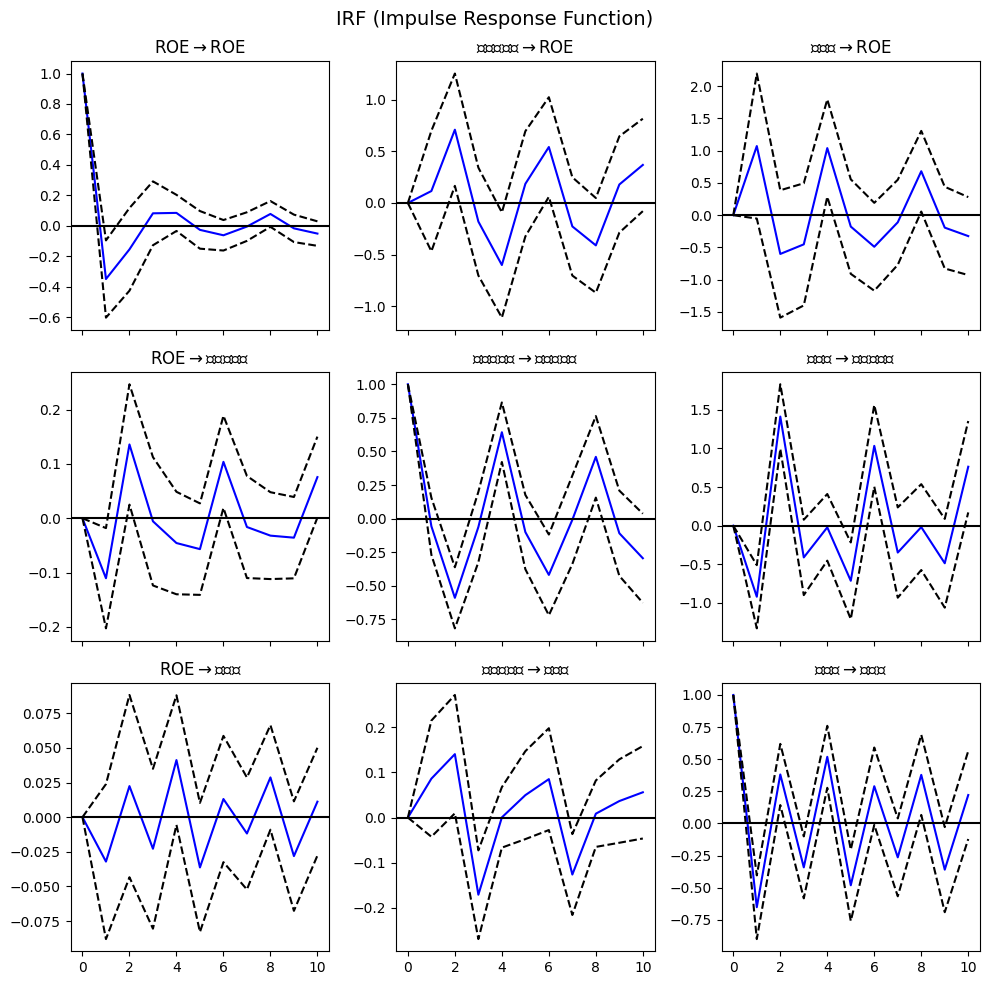

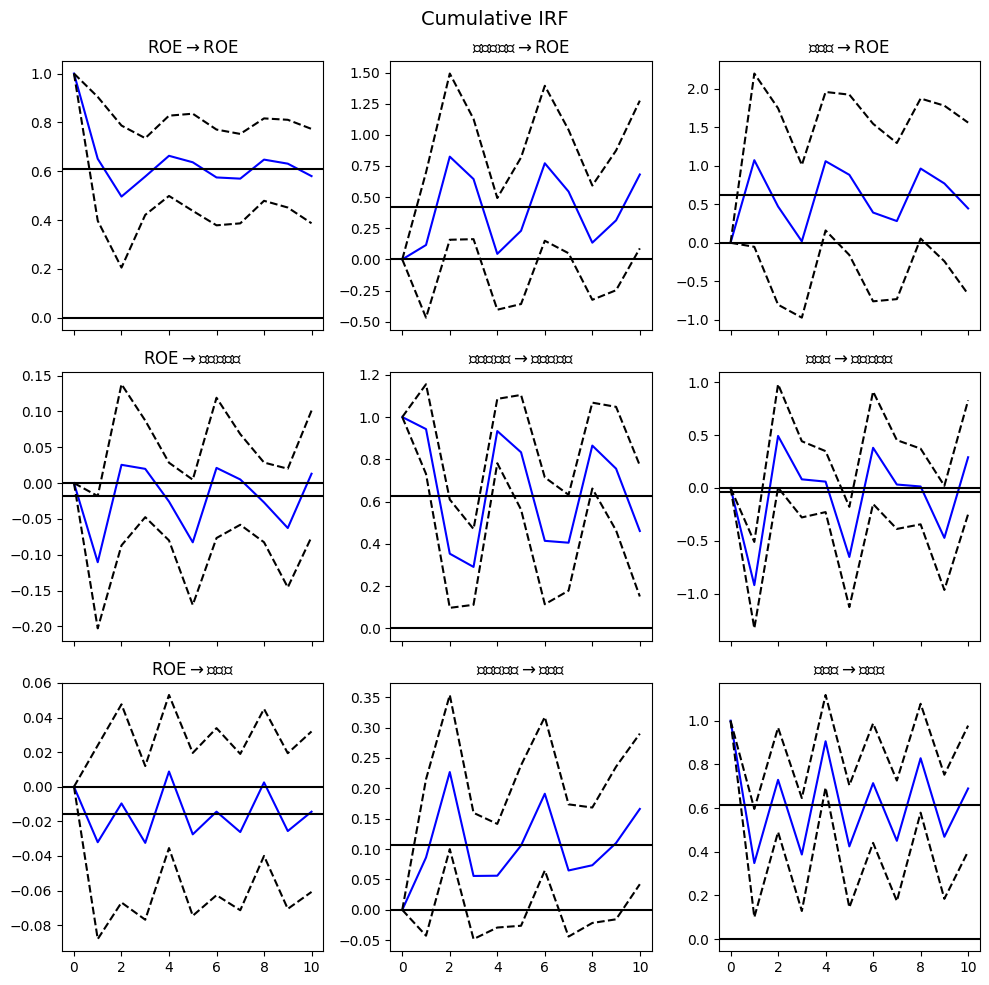

In [15]:
# IRF 객체 생성
irf = results.irf(10)  # 시차 10까지

# 1. 전체 IRF
irf.plot(orth=False)
plt.suptitle("IRF (Impulse Response Function)", fontsize=14)
plt.tight_layout()
plt.show()

# 2. 누적 IRF
irf.plot_cum_effects(orth=False)
plt.suptitle("Cumulative IRF", fontsize=14)
plt.tight_layout()
plt.show()


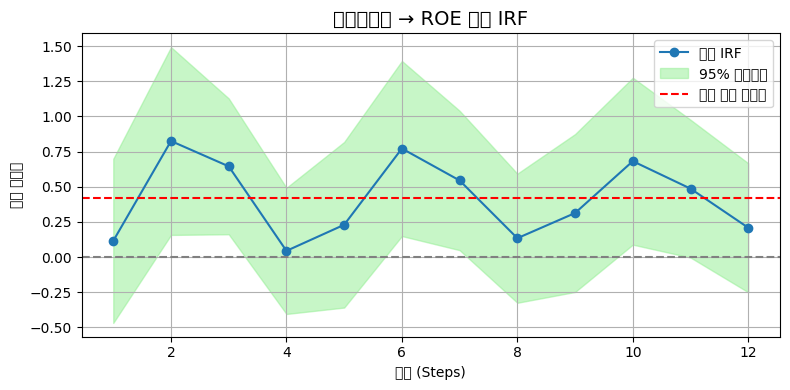

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import VAR

model = VAR(df_var)              # ✅ df_var는 VAR 분석에 사용할 데이터프레임
var_res = model.fit(maxlags=2)   # ✅ AIC/BIC 기준 적절한 시차 선택


# ✅ 1. 충격반응분석 객체 생성 (시차 horizon 지정)
horizon = 12  # 분석 시차: 8분기까지
irf = var_res.irf(horizon)

# ✅ 2. 변수명 설정 (충격변수 → 반응변수)
impulse_var  = '연구개발비'
response_var = 'ROE'

# ✅ 누적 IRF 및 신뢰구간 (시차 1~horizon까지만 사용)
cum_irf_vals = irf.cum_effects[1:horizon+1, resp_idx, imp_idx]
stderr_vals = irf.cum_effect_stderr(orth=False)[1:horizon+1, resp_idx, imp_idx]
ci_upper = cum_irf_vals + 1.96 * stderr_vals
ci_lower = cum_irf_vals - 1.96 * stderr_vals
mean_val = np.mean(cum_irf_vals)

# ✅ 시각화 (x축도 range(1, horizon+1)로 조정)
plt.figure(figsize=(8, 4))
plt.plot(range(1, horizon+1), cum_irf_vals, marker='o', label='누적 IRF')
plt.fill_between(range(1, horizon+1), ci_lower, ci_upper, color='lightgreen', alpha=0.5, label='95% 신뢰구간')
plt.axhline(0, color='gray', linestyle='--')
plt.axhline(mean_val, color='red', linestyle='--', label='평균 누적 반응값')
plt.title(f'{impulse_var} → {response_var} 누적 IRF', fontsize=14)
plt.xlabel('시차 (Steps)')
plt.ylabel('누적 반응값')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


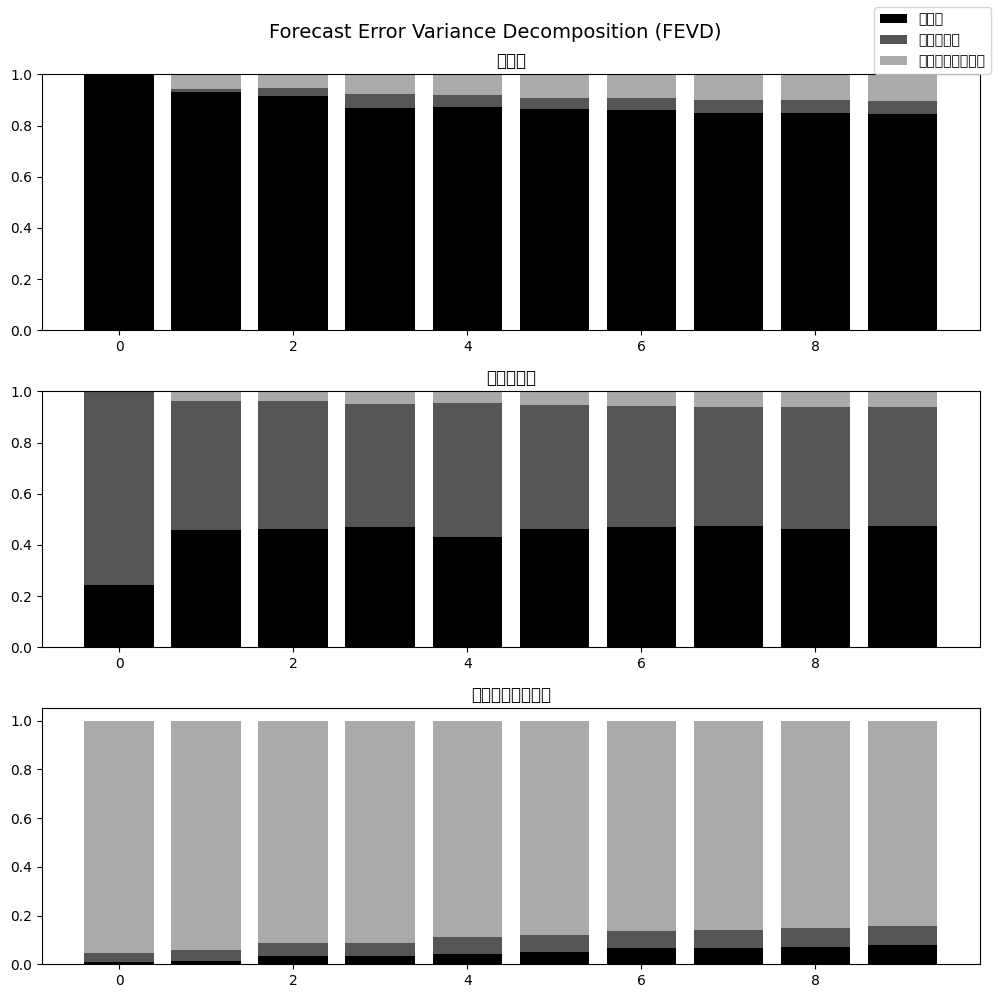

In [9]:
# FEVD 객체 생성 (시차 10까지)
fevd = results.fevd(10)

# 1. 시각화
fevd.plot()
plt.suptitle("Forecast Error Variance Decomposition (FEVD)", fontsize=14)
plt.tight_layout()
plt.show()